In [1]:
import os
import pandas as pd
from typing import List, Tuple
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
from train_utils import OffPolicyTrainer
from world_cup_env import WorldCupEnv
from agent import DoubleDQNAgent

font = {'size': 16}

matplotlib.rc('font', **font)

In [2]:
DATASET_PATH = "../dataset"
INDEX_FIELD = "timestamp"
DATA_FIELD = "num_request"
CPD_CANDIDATE_ROOT = "../05_binseg_series/binseg_cpd_candidate"
N_LOOKBACK = 4
N_PREDICT = 2

STATE_DICT_ROOT = "state_dict"

In [3]:
def get_data_file_list(dataset_path: str) -> List[str]:
    return os.listdir(dataset_path)

In [4]:
def read_dataset(csv_path: str,index_field:str,data_field:str) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path)
    return df[index_field].to_numpy(), df[data_field].to_numpy()

In [5]:
def read_candidate_cpds(path: str) -> List[int]:
    candidate_cpds = None
    with open(path, "r") as f:
        candidate_cpds = json.load(f)
    return candidate_cpds

In [6]:
workload_to_skip_list = ["workload_1998-06-13", "workload_1998-06-14", "workload_1998-06-20", "workload_1998-06-21", "workload_1998-06-27", "workload_1998-06-28","workload_1998-07-04"]

read workload_1998-06-10.csv
eval results: reward -41.354615
eval results: reward -41.354615
read workload_1998-06-11.csv
eval results: reward -34.869162
eval results: reward -34.869162
read workload_1998-06-12.csv
eval results: reward -28.930703
eval results: reward -28.930703
read workload_1998-06-15.csv
eval results: reward -47.565690
eval results: reward -47.565690
read workload_1998-06-16.csv
eval results: reward -15.482456
eval results: reward -15.482456
read workload_1998-06-17.csv
eval results: reward -19.897727
eval results: reward -19.897727
read workload_1998-06-18.csv
eval results: reward -15.636750
eval results: reward -15.636750
read workload_1998-06-19.csv
eval results: reward -18.123966
eval results: reward -18.123966
read workload_1998-06-22.csv
eval results: reward -22.693531
eval results: reward -22.693531
read workload_1998-06-23.csv
eval results: reward -53.706583
eval results: reward -53.706583
read workload_1998-06-24.csv
eval results: reward -37.819260
eval resu

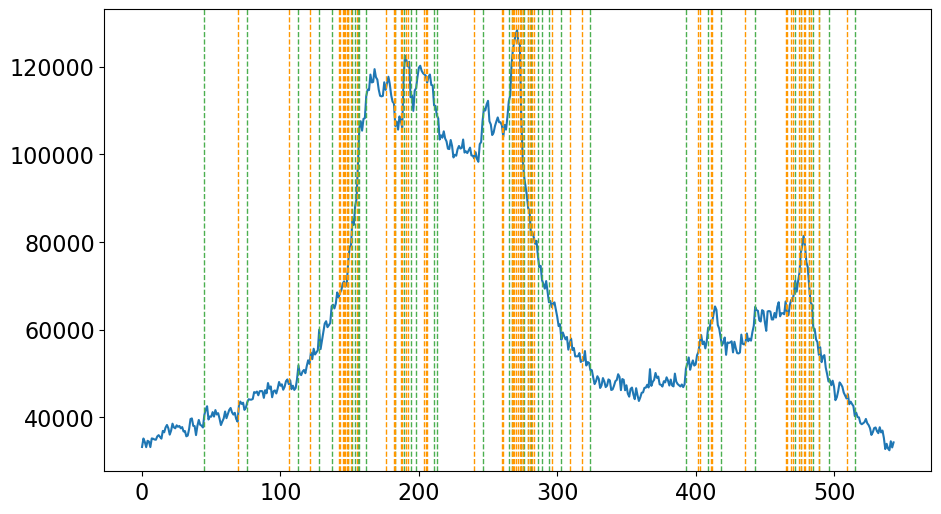

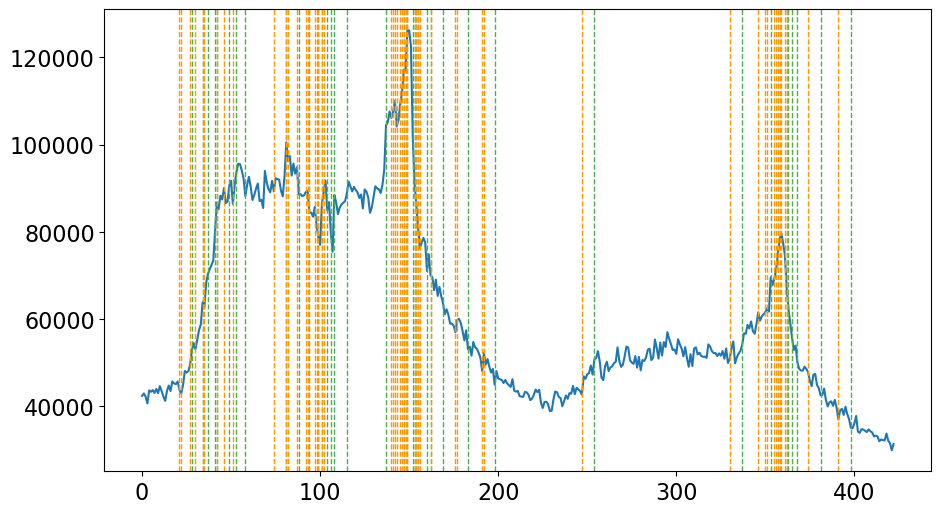

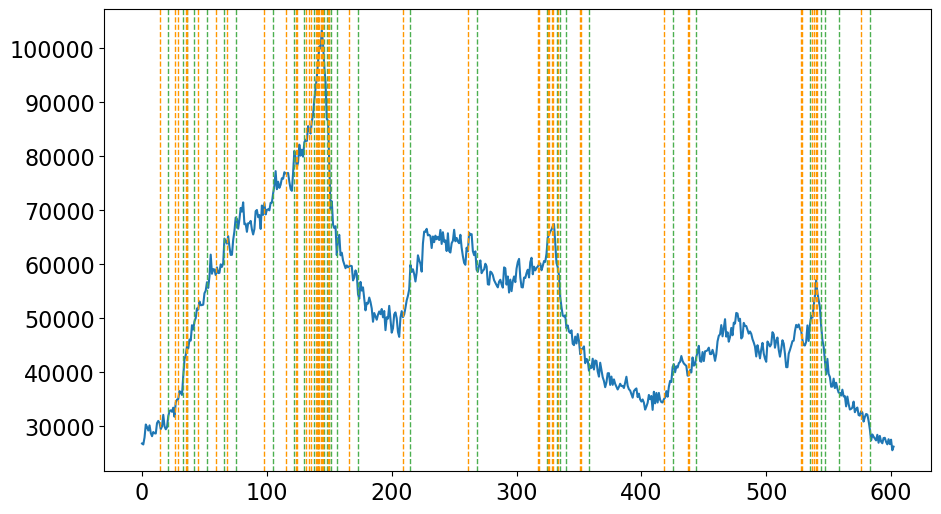

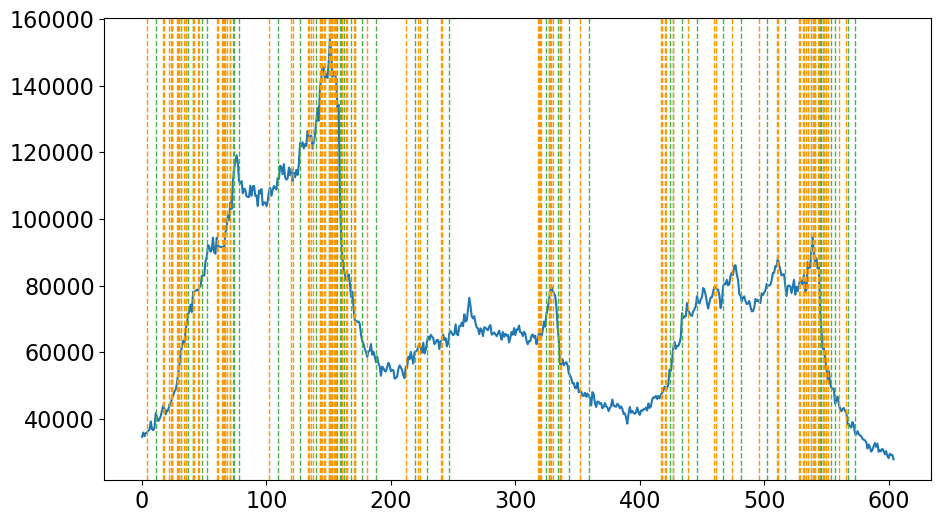

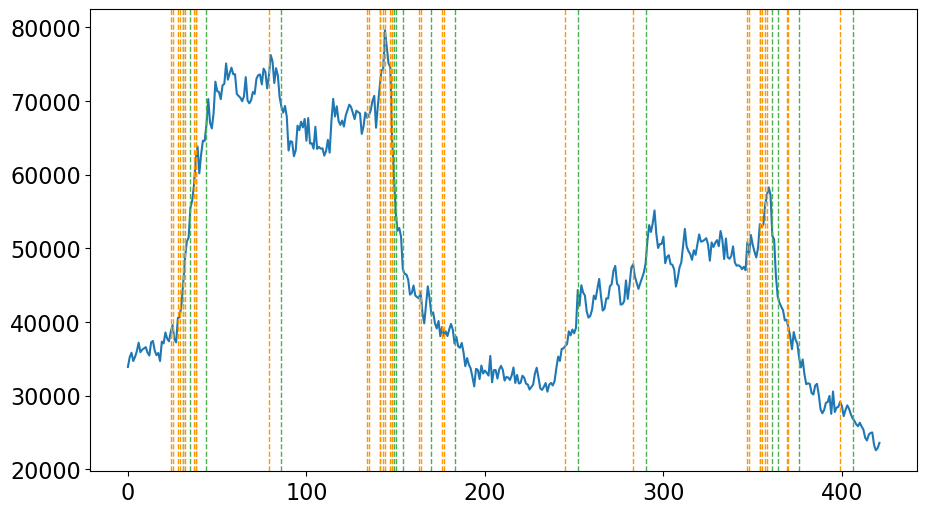

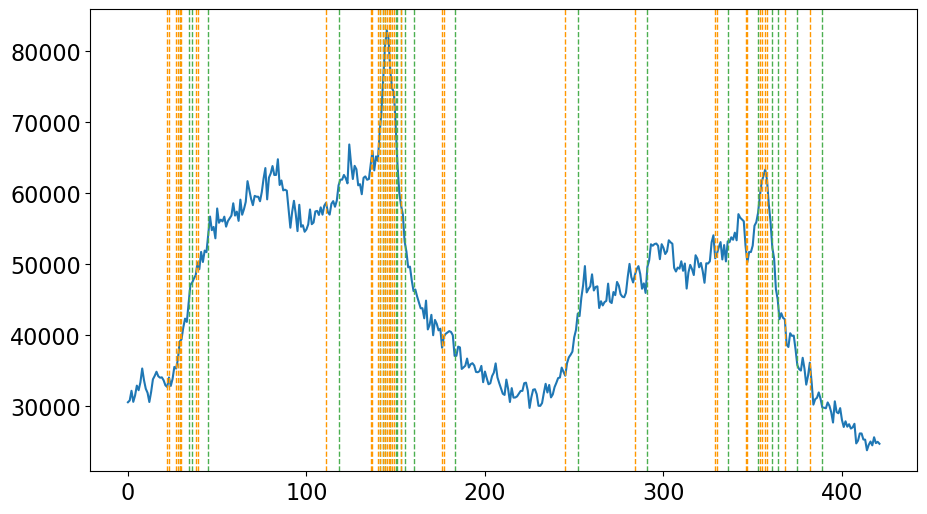

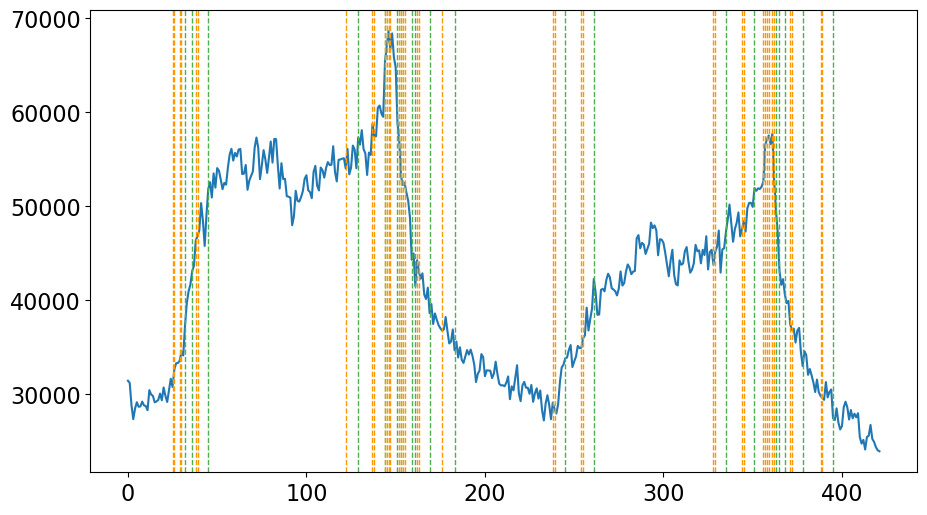

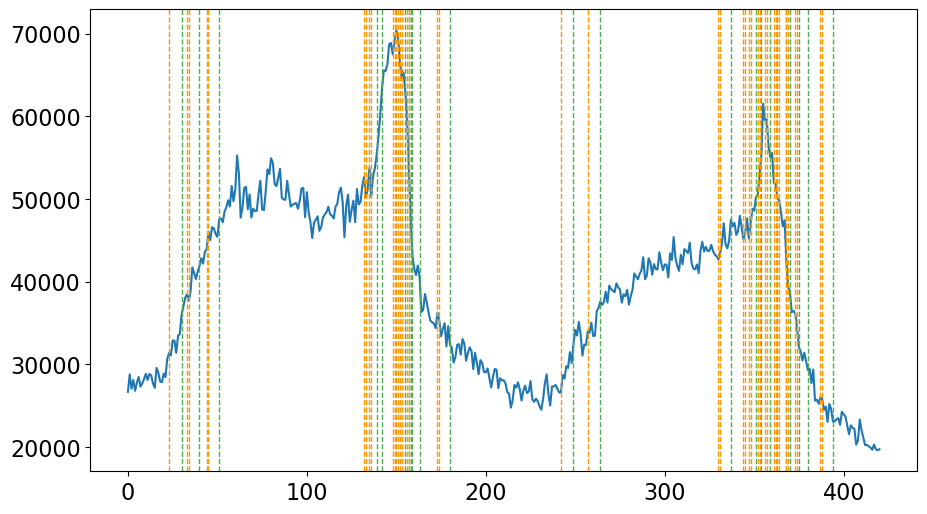

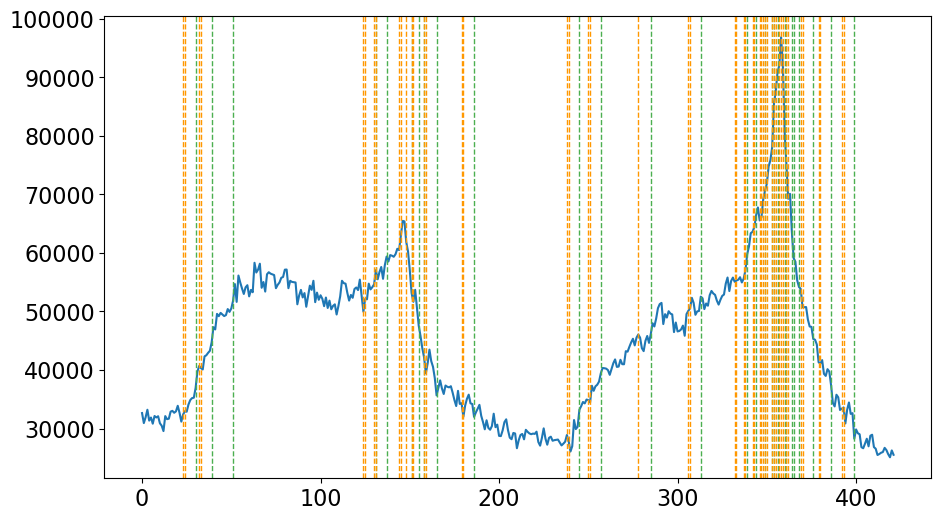

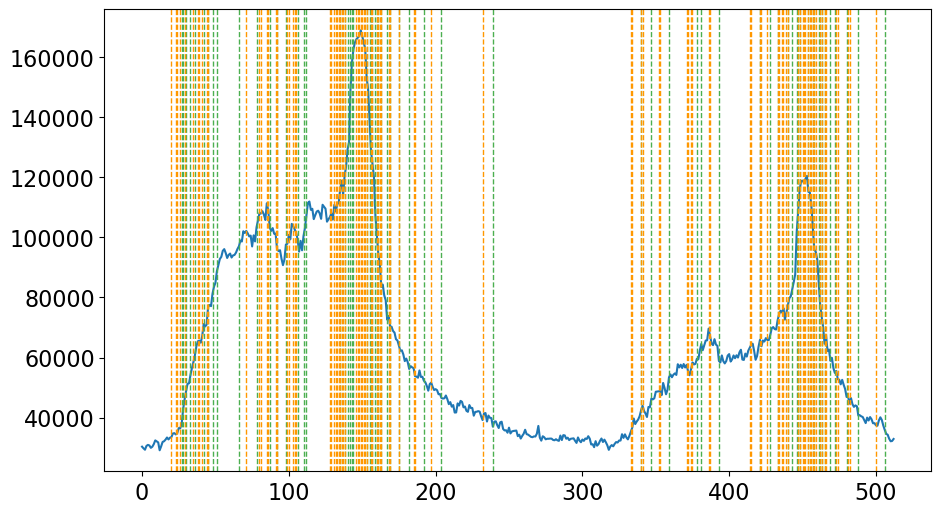

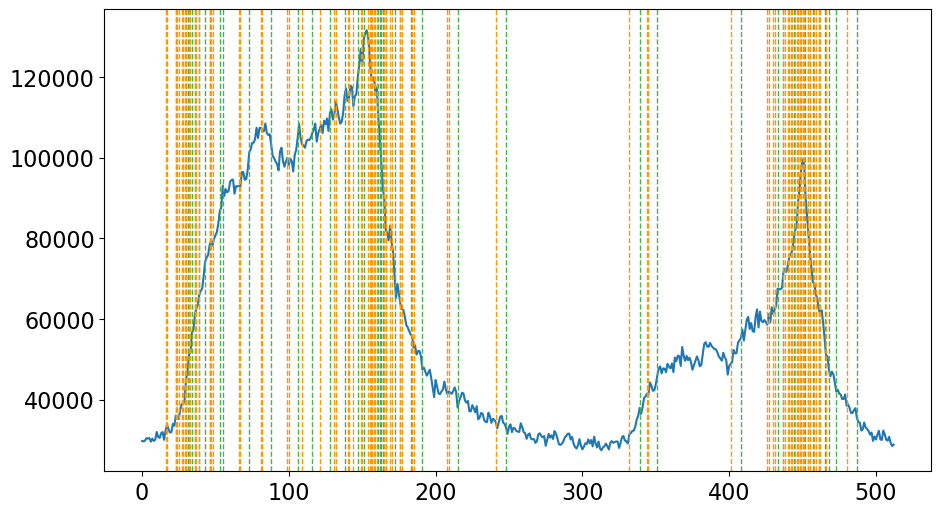

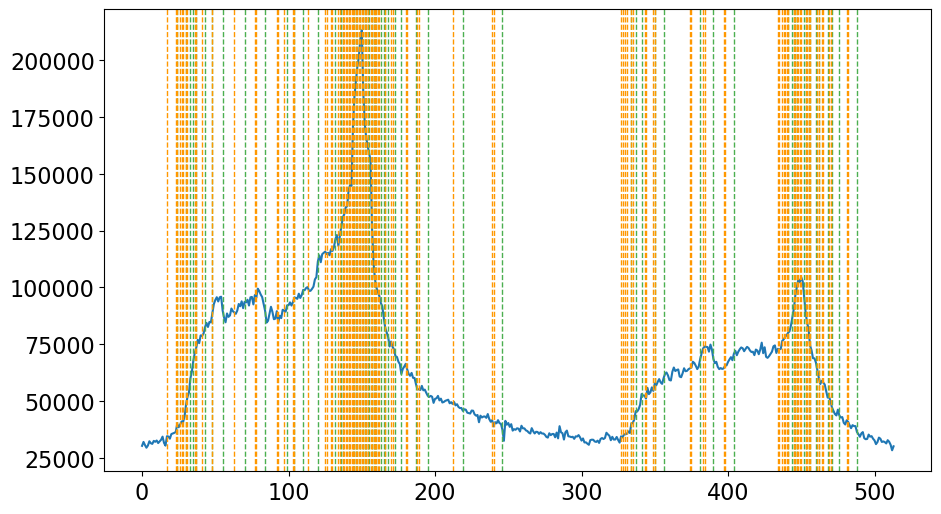

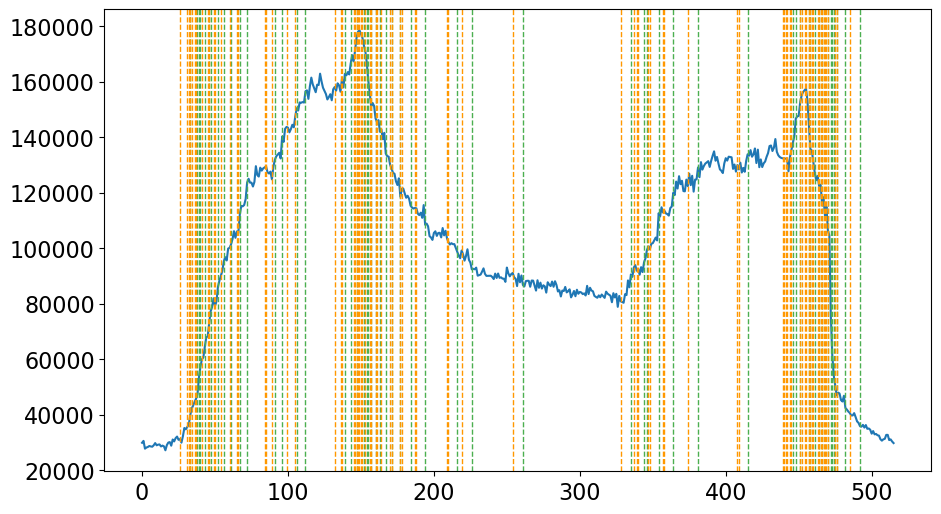

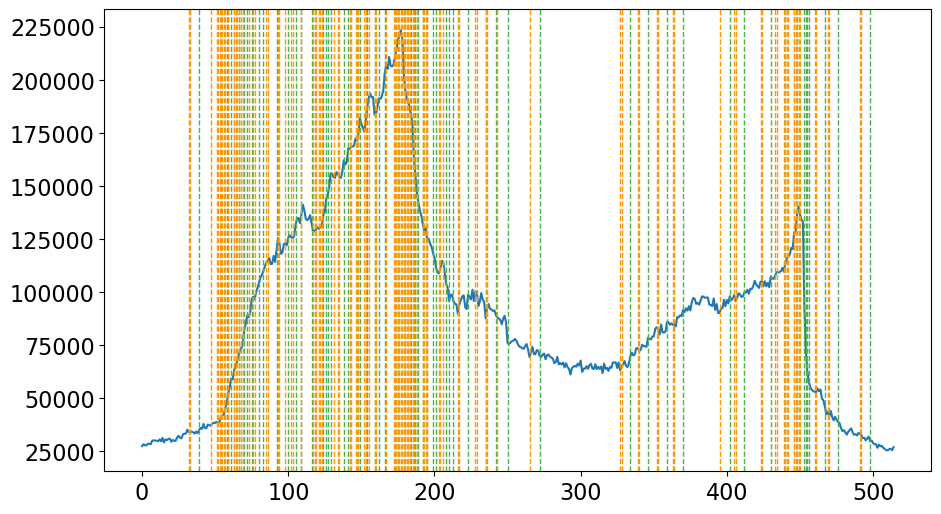

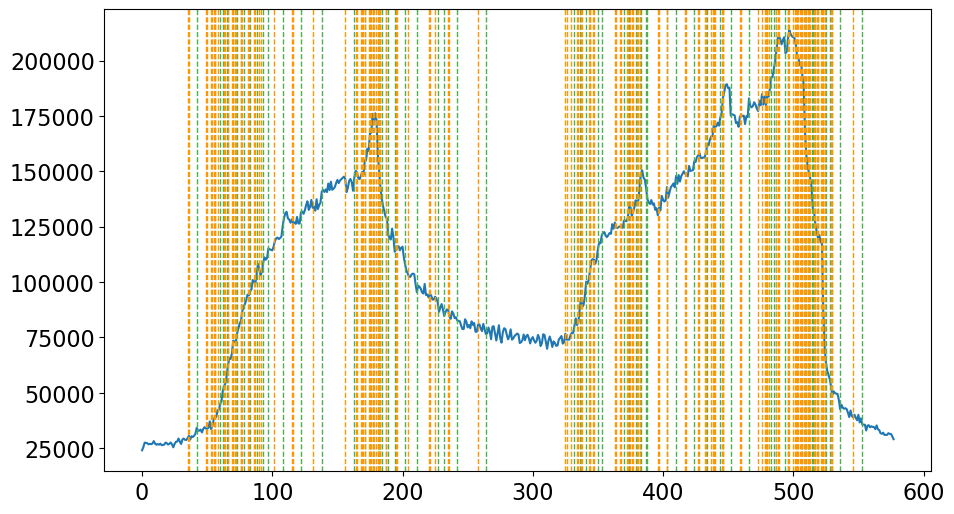

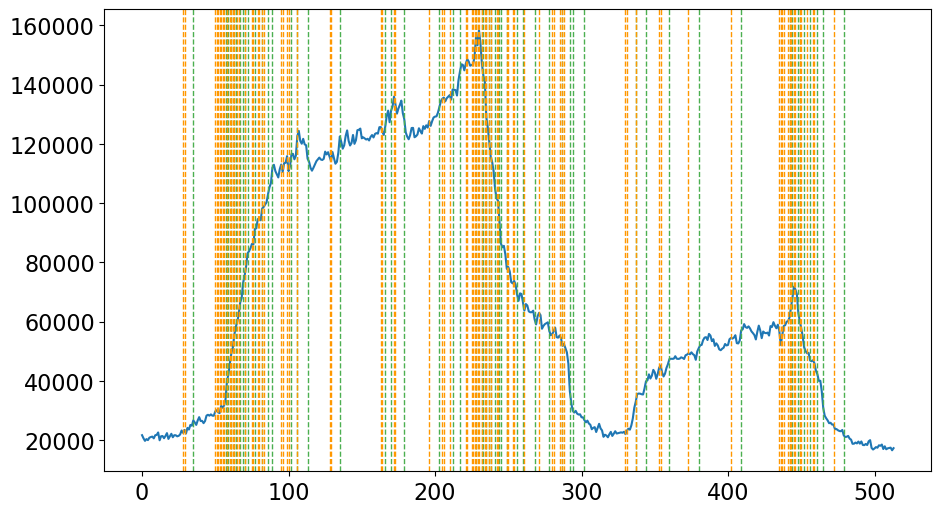

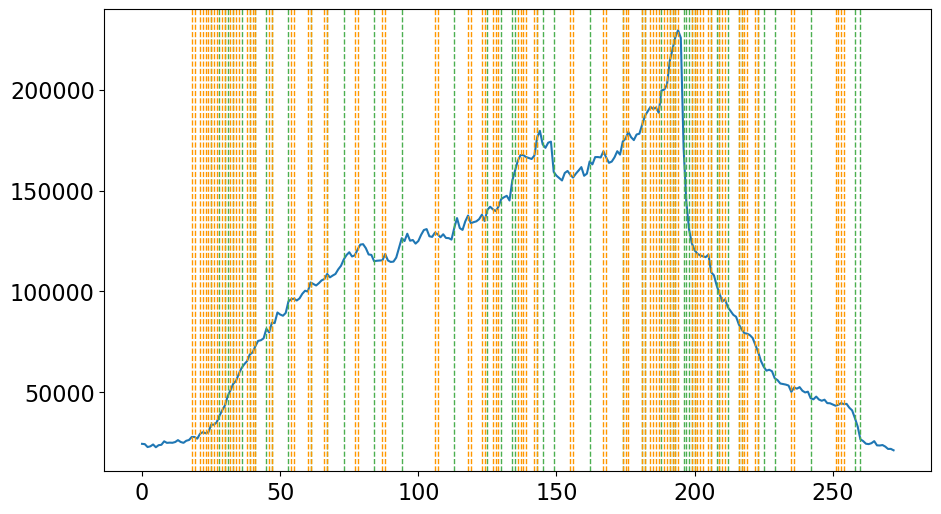

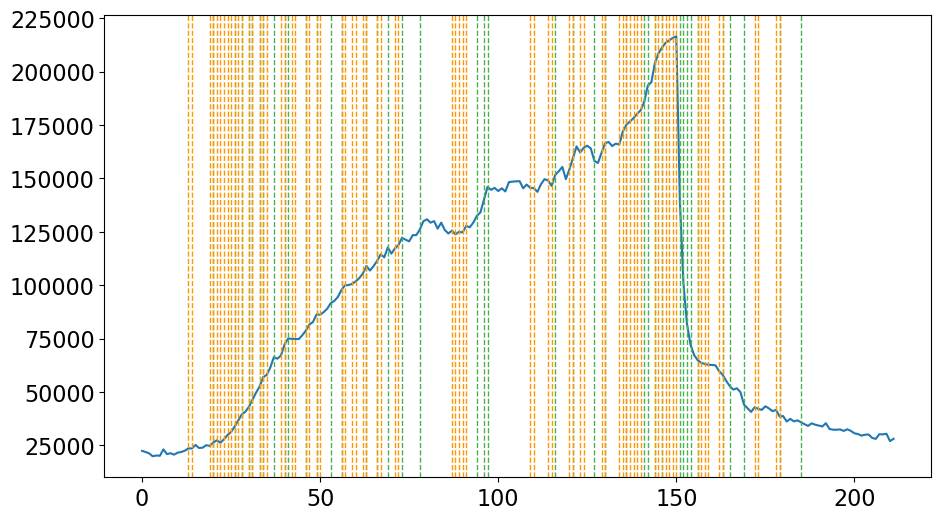

In [7]:
import json
data_file_list = get_data_file_list(DATASET_PATH)
state_list = None
action_list = None
env = None
agent = DoubleDQNAgent(2)
trainer = OffPolicyTrainer(env, agent, num_episodes=100, replay_buffer_size=128, batch_size=32, discount_factor=0.9, epsilon_start=0.5, epsilon_end=0.1, epsilon_step=20, learning_rate_start=1e-3, learning_rate_end=1e-4, learning_rate_step=100, tau=0.05)
for file_name in data_file_list:
    workload_name = file_name.split(".")[0]
    if workload_name in workload_to_skip_list:
        continue
    print("read %s" % (file_name))
    np_index, np_data = read_dataset(os.path.join(DATASET_PATH, file_name), INDEX_FIELD, DATA_FIELD)
    np_data = np_data/20000.0
    workload_diff = np.diff(np_data).reshape((-1, 1))
    candidate_cpds = read_candidate_cpds(os.path.join(CPD_CANDIDATE_ROOT, workload_name+".json"))
    env = WorldCupEnv(workload_diff, candidate_cpds, N_LOOKBACK, N_PREDICT)
    agent.load(os.path.join(STATE_DICT_ROOT, workload_name+".pth"))
    trainer.set_env(env)
    trainer.eval()
    state_list, action_list = trainer.eval()
    np_data = np_data*20000.0
    fig, ax = plt.subplots()
    fig.set_size_inches(16/1.5, 9/1.5)
    cpds_pd = np.where(np.array(action_list) == 1)[0]
    ax.plot(np_data)
    for cp in candidate_cpds:
        ax.axvline(x=cp, color="#4CAF50", linestyle='--', linewidth=1)
    for cp in cpds_pd:
        ax.axvline(x=cp, color="#FF9800", linestyle='--', linewidth=1)